# Notebook 1 - Dataset Cresci 2017 - Teste 1

Link do Dataset: https://botometer.osome.iu.edu/bot-repository/datasets.html

## Objetivos

• Encontrar métricas eficientes para avaliar se uma conta é um bot simples(apenas para gerar seguidores).

• Avaliar o desempenho de diferentes algoritmos para os mesmos dados.
        

## Composição dos Dados de Treino/Teste

Nesse teste, utilizaremos os dados dos seguintes datasets: fake_followers e genuine_accounts. 
O dataframe usado para o treino de diversos modelos de machine learning é composto de 50% de contas bots(fake_followers) e 50% de contas legítimas(genuine_accounts).
Os dados que serão usados para teste seguem exatamente a mesma composição explicada anteriormente.

Relativo ao dataset de treino, ele utiliza 75% dos dados do dataset fake_followers, já o dataset de teste é composto por 25%.
A proporção se mantém a igual para os dados referentes as contas genuínas. 

# Escolha das features

A escolha dos dados relevantes foi feita considerando 3 grandes fatores:

1 - A disponibilidade de tais informações na versão atual da API oficial do Twitter.

2 - Os artigos: Supervised Machine Learning Bot Detection Techniques to Identify Social Twitter Bots e The Paradigm-Shift of Social Spambots: Evidence, Theories, and Tools for the Arms Race que revisam o estado da arte na identificação de perfis bot.

3 - Minhas hipoteses que serão explicadas posteriormente. 

### Libs que serão utilizadas para a realização dos testes:

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


Para fazer a visualização da árvore de decisão é necessário instalar a lib graphviz para isso use o comando acima. Além disso, instale o graphviz em seu sistema operacional

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from math import sqrt

Para melhorar a visualização dos dataframes:

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Nesse trecho do código fazemos a leitura do arquivo de usuários da base de dados de fake_followers. E em seguida mostramos a dimensão dos dados obtidos, sendo 3351 linhas(registros) e 38 colunas(features).


In [4]:
fake_followers = pd.read_csv("../datasets/fake_followers/users.csv")
fake_followers.shape

(3351, 38)

Como todos os perfis dessa base de dados são perfis bot, criaremos uma coluna adicional no dataframe sinalizando tal fato para que possamos diferenciar os diferentes tipos de pefil posteriormente.

In [5]:
fake_followers['is_bot'] = 1

Faremos o mesmo para o arquivo de perfis verdadeiros. Porém, dessa vez, sinalizaremos os perfis como 0.

In [6]:
real_accounts = pd.read_csv("../datasets/genuine_accounts/users.csv")
real_accounts.shape

(3474, 42)

In [7]:
real_accounts['is_bot'] = 0

Em seguida, analisaremos alguns dos dados obtidos a fim de avaliar o que utilizaremos para fazer a predição se um perfil é bot ou não. 

In [8]:
fake_followers.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,updated,is_bot
0,80479674,YI YUAN,yi_twitts,29,19,255,1,0,Wed Oct 07 03:19:21 +0000 2009,http://www.jycondo.com,en,Eastern Time (US & Canada),toronto,NaN,NaN,1.0,http://a0.twimg.com/profile_images/1832741069/...,NaN,1.0,https://si0.twimg.com/images/themes/theme14/bg...,333333,https://si0.twimg.com/profile_images/183274106...,eeeeee,1.0,efefef,http://a0.twimg.com/images/themes/theme14/bg.gif,131516,009999,-18000.0,NaN,NaN,NaN,NaN,NaN,real estate sales,NaN,NaN,2013-06-12 18:38:35,1
1,82487179,Marcos Perez C,marcos_peca,1408,208,866,138,0,Wed Oct 14 23:40:17 +0000 2009,NaN,es,Mexico City,NaN,NaN,NaN,1.0,http://a0.twimg.com/profile_images/3106285928/...,https://si0.twimg.com/profile_banners/82487179...,1.0,https://si0.twimg.com/images/themes/theme6/bg.gif,333333,https://si0.twimg.com/profile_images/310628592...,86A4A6,NaN,A0C5C7,http://a0.twimg.com/images/themes/theme6/bg.gif,709397,FF3300,-21600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-12 18:38:35,1
2,105830531,curti lorenzo,curtilorenzo,39,59,962,8,0,Sun Jan 17 16:46:52 +0000 2010,http://www.valcavargna.com/,it,London,San Bartolomeo Val Cavargna CO,NaN,NaN,NaN,http://a0.twimg.com/profile_images/1743973394/...,NaN,1.0,https://si0.twimg.com/profile_background_image...,333333,https://si0.twimg.com/profile_images/174397339...,A8C7F7,NaN,C0DFEC,http://a0.twimg.com/profile_background_images/...,022330,0084B4,0.0,NaN,NaN,NaN,NaN,NaN,le corna del capro scappato dal gregge s'infil...,NaN,NaN,2013-06-12 18:38:35,1
3,114488344,ruben dario toscano,gatito2710,59,7,49,4,0,Mon Feb 15 15:49:58 +0000 2010,NaN,es,Lima,peru,1.0,NaN,NaN,http://a0.twimg.com/profile_images/1174713108/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,333333,https://si0.twimg.com/profile_images/117471310...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,-18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-12 18:38:35,1
4,123222267,Malek Khalaf,MalekKhalaf,987,60,521,61,1,Mon Mar 15 11:38:55 +0000 2010,http://www.facebook.com/Malek.AlBalawi,en,Riyadh,"31.975193,35.920294",NaN,NaN,1.0,http://a0.twimg.com/profile_images/2861541411/...,https://si0.twimg.com/profile_banners/12322226...,NaN,https://si0.twimg.com/profile_background_image...,DDE1E4,https://si0.twimg.com/profile_images/286154141...,000002,NaN,A9A09B,http://a0.twimg.com/profile_background_images/...,D9FBFC,C0C3CC,10800.0,NaN,NaN,NaN,NaN,NaN,"MA student at JU, Interested in Juventus,Italy...",NaN,NaN,2013-06-11 17:39:44,1


In [9]:
real_accounts.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2,is_bot
0,1502026416,TASUKU HAYAKAWA,0918Bask,2177,208,332,265,1,NaN,ja,NaN,Tokyo .Japan .,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5887331863...,https://pbs.twimg.com/profile_banners/15020264...,NaN,https://abs.twimg.com/images/themes/theme1/bg.png,000000,https://pbs.twimg.com/profile_images/588733186...,000000,NaN,000000,http://abs.twimg.com/images/themes/theme1/bg.png,000000,EB0C1F,NaN,NaN,NaN,NaN,NaN,NaN,15years ago X.Lines24,NaN,NaN,Tue Jun 11 11:20:35 +0000 2013,2013-06-11 13:20:35,2015-05-02 06:41:46,2016-03-15 15:53:47,0,0,0
1,2492782375,ro_or,1120Roll,2660,330,485,3972,5,NaN,ja,Tokyo,神奈川県横浜市,1.0,NaN,1.0,http://pbs.twimg.com/profile_images/5737442928...,https://pbs.twimg.com/profile_banners/24927823...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/573744292...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,32400.0,NaN,NaN,NaN,NaN,NaN,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),NaN,NaN,Tue May 13 10:37:57 +0000 2014,2014-05-13 12:37:57,2015-05-01 17:20:27,2016-03-15 15:53:48,0,0,0
2,293212315,bearclaw,14KBBrown,1254,166,177,1185,0,NaN,en,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5908597242...,https://pbs.twimg.com/profile_banners/29321231...,1.0,https://pbs.twimg.com/profile_background_image...,0F9A89,https://pbs.twimg.com/profile_images/590859724...,EED96D,1.0,EED96D,http://pbs.twimg.com/profile_background_images...,E63A50,E63A50,-14400.0,NaN,NaN,NaN,NaN,NaN,Let me see what your best move is!,NaN,NaN,Wed May 04 23:30:37 +0000 2011,2011-05-05 01:30:37,2015-05-01 18:48:28,2016-03-15 15:53:48,0,0,0
3,191839658,pocahontas farida,wadespeters,202968,2248,981,60304,101,http://t.co/rGV0HIJGsu,en,Greenland,#freePalestine - rip paul,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5915979249...,https://pbs.twimg.com/profile_banners/19183965...,1.0,https://abs.twimg.com/images/themes/theme3/bg.gif,634047,https://pbs.twimg.com/profile_images/591597924...,D3D2CF,NaN,E3E2DE,http://abs.twimg.com/images/themes/theme3/bg.gif,EDECE9,088253,-7200.0,NaN,NaN,NaN,NaN,NaN,20. menna: #farida #nyc and the 80s actually y...,NaN,NaN,Fri Sep 17 14:02:10 +0000 2010,2010-09-17 16:02:10,2015-05-01 13:55:16,2016-03-15 15:53:48,0,0,0
4,3020965143,Ms Kathy,191a5bd05da04dc,82,21,79,5,0,NaN,en,NaN,Wichita KS,1.0,NaN,NaN,http://pbs.twimg.com/profile_images/5635511026...,NaN,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/563551102...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,Cosmetologist,NaN,NaN,Fri Feb 06 04:10:49 +0000 2015,2015-02-06 05:10:49,2015-05-02 01:17:32,2016-03-15 15:53:48,0,0,0


In [10]:
fake_followers.describe()

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,contributors_enabled,following,is_bot
count,3.351000e+03,3351.000000,3351.000000,3351.000000,3351.000000,3351.000000,3034.0,6.0,139.0,3342.0,170.0,335.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3351.0
mean,7.442362e+08,71.898239,17.740376,370.059684,4.299612,0.073113,1.0,1.0,1.0,1.0,1.0,-8602.388060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,3.862041e+08,634.979715,54.223193,212.552488,59.551501,0.882176,0.0,0.0,0.0,0.0,0.0,17982.652826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,1.093557e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,6.162063e+08,16.000000,8.000000,217.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-21600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,6.177103e+08,23.000000,12.000000,305.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-14400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.174438e+09,39.000000,18.000000,529.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
max,1.391998e+09,33128.000000,1624.000000,2004.000000,1402.000000,32.000000,1.0,1.0,1.0,1.0,1.0,43200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [11]:
fake_followers.dtypes

id                                      int64
name                                   object
screen_name                            object
statuses_count                          int64
followers_count                         int64
friends_count                           int64
favourites_count                        int64
listed_count                            int64
created_at                             object
url                                    object
lang                                   object
time_zone                              object
location                               object
default_profile                       float64
default_profile_image                 float64
geo_enabled                           float64
profile_image_url                      object
profile_banner_url                     object
profile_use_background_image          float64
profile_background_image_url_https     object
profile_text_color                     object
profile_image_url_https           

In [12]:
del fake_followers['is_translator']
del fake_followers['follow_request_sent']
del fake_followers['protected']
del fake_followers['contributors_enabled']
del fake_followers['following']
del fake_followers['notifications']
del fake_followers['profile_link_color']
del fake_followers['profile_background_color']
del fake_followers['profile_sidebar_fill_color']
del fake_followers['profile_sidebar_border_color']
del fake_followers['profile_text_color']
del fake_followers['profile_background_tile']
del fake_followers['updated']
del fake_followers['utc_offset']
del fake_followers['lang']
del fake_followers['time_zone']
del fake_followers['created_at']

In [13]:
fake_followers.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_image_url_https,profile_background_image_url,verified,description,is_bot
0,80479674,YI YUAN,yi_twitts,29,19,255,1,0,http://www.jycondo.com,toronto,NaN,NaN,1.0,http://a0.twimg.com/profile_images/1832741069/...,NaN,1.0,https://si0.twimg.com/images/themes/theme14/bg...,https://si0.twimg.com/profile_images/183274106...,http://a0.twimg.com/images/themes/theme14/bg.gif,NaN,real estate sales,1
1,82487179,Marcos Perez C,marcos_peca,1408,208,866,138,0,NaN,NaN,NaN,NaN,1.0,http://a0.twimg.com/profile_images/3106285928/...,https://si0.twimg.com/profile_banners/82487179...,1.0,https://si0.twimg.com/images/themes/theme6/bg.gif,https://si0.twimg.com/profile_images/310628592...,http://a0.twimg.com/images/themes/theme6/bg.gif,NaN,NaN,1
2,105830531,curti lorenzo,curtilorenzo,39,59,962,8,0,http://www.valcavargna.com/,San Bartolomeo Val Cavargna CO,NaN,NaN,NaN,http://a0.twimg.com/profile_images/1743973394/...,NaN,1.0,https://si0.twimg.com/profile_background_image...,https://si0.twimg.com/profile_images/174397339...,http://a0.twimg.com/profile_background_images/...,NaN,le corna del capro scappato dal gregge s'infil...,1
3,114488344,ruben dario toscano,gatito2710,59,7,49,4,0,NaN,peru,1.0,NaN,NaN,http://a0.twimg.com/profile_images/1174713108/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,https://si0.twimg.com/profile_images/117471310...,http://a0.twimg.com/images/themes/theme1/bg.png,NaN,NaN,1
4,123222267,Malek Khalaf,MalekKhalaf,987,60,521,61,1,http://www.facebook.com/Malek.AlBalawi,"31.975193,35.920294",NaN,NaN,1.0,http://a0.twimg.com/profile_images/2861541411/...,https://si0.twimg.com/profile_banners/12322226...,NaN,https://si0.twimg.com/profile_background_image...,https://si0.twimg.com/profile_images/286154141...,http://a0.twimg.com/profile_background_images/...,NaN,"MA student at JU, Interested in Juventus,Italy...",1


In [14]:
fake_followers.describe()

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,verified,is_bot
count,3.351000e+03,3351.000000,3351.000000,3351.000000,3351.000000,3351.000000,3034.0,6.0,139.0,3342.0,0.0,3351.0
mean,7.442362e+08,71.898239,17.740376,370.059684,4.299612,0.073113,1.0,1.0,1.0,1.0,NaN,1.0
std,3.862041e+08,634.979715,54.223193,212.552488,59.551501,0.882176,0.0,0.0,0.0,0.0,NaN,0.0
min,1.093557e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,NaN,1.0
25%,6.162063e+08,16.000000,8.000000,217.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,NaN,1.0
50%,6.177103e+08,23.000000,12.000000,305.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,NaN,1.0
75%,1.174438e+09,39.000000,18.000000,529.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,NaN,1.0
max,1.391998e+09,33128.000000,1624.000000,2004.000000,1402.000000,32.000000,1.0,1.0,1.0,1.0,NaN,1.0


In [15]:
del real_accounts['is_translator']
del real_accounts['follow_request_sent']
del real_accounts['protected']
del real_accounts['contributors_enabled']
del real_accounts['following']
del real_accounts['notifications']
del real_accounts['profile_link_color']
del real_accounts['profile_background_color']
del real_accounts['profile_sidebar_fill_color']
del real_accounts['profile_sidebar_border_color']
del real_accounts['profile_text_color']
del real_accounts['profile_background_tile']
del real_accounts['updated']
del real_accounts['utc_offset']
del real_accounts['lang']
del real_accounts['time_zone']
del real_accounts['test_set_1']
del real_accounts['test_set_2']
del real_accounts['crawled_at']
del real_accounts['timestamp']

In [16]:
real_accounts.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_image_url_https,profile_background_image_url,verified,description,created_at,is_bot
0,1502026416,TASUKU HAYAKAWA,0918Bask,2177,208,332,265,1,NaN,Tokyo .Japan .,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5887331863...,https://pbs.twimg.com/profile_banners/15020264...,NaN,https://abs.twimg.com/images/themes/theme1/bg.png,https://pbs.twimg.com/profile_images/588733186...,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,15years ago X.Lines24,Tue Jun 11 11:20:35 +0000 2013,0
1,2492782375,ro_or,1120Roll,2660,330,485,3972,5,NaN,神奈川県横浜市,1.0,NaN,1.0,http://pbs.twimg.com/profile_images/5737442928...,https://pbs.twimg.com/profile_banners/24927823...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,https://pbs.twimg.com/profile_images/573744292...,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),Tue May 13 10:37:57 +0000 2014,0
2,293212315,bearclaw,14KBBrown,1254,166,177,1185,0,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5908597242...,https://pbs.twimg.com/profile_banners/29321231...,1.0,https://pbs.twimg.com/profile_background_image...,https://pbs.twimg.com/profile_images/590859724...,http://pbs.twimg.com/profile_background_images...,NaN,Let me see what your best move is!,Wed May 04 23:30:37 +0000 2011,0
3,191839658,pocahontas farida,wadespeters,202968,2248,981,60304,101,http://t.co/rGV0HIJGsu,#freePalestine - rip paul,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5915979249...,https://pbs.twimg.com/profile_banners/19183965...,1.0,https://abs.twimg.com/images/themes/theme3/bg.gif,https://pbs.twimg.com/profile_images/591597924...,http://abs.twimg.com/images/themes/theme3/bg.gif,NaN,20. menna: #farida #nyc and the 80s actually y...,Fri Sep 17 14:02:10 +0000 2010,0
4,3020965143,Ms Kathy,191a5bd05da04dc,82,21,79,5,0,NaN,Wichita KS,1.0,NaN,NaN,http://pbs.twimg.com/profile_images/5635511026...,NaN,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,https://pbs.twimg.com/profile_images/563551102...,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,Cosmetologist,Fri Feb 06 04:10:49 +0000 2015,0


Aqui, definimos nosso base de treino, concatenando os dados tratados dos usuários e das contas falsas.

In [17]:
df_train = pd.concat([fake_followers, real_accounts],ignore_index=True)

In [18]:
df_train.dtypes

id                                      int64
name                                   object
screen_name                            object
statuses_count                          int64
followers_count                         int64
friends_count                           int64
favourites_count                        int64
listed_count                            int64
url                                    object
location                               object
default_profile                       float64
default_profile_image                 float64
geo_enabled                           float64
profile_image_url                      object
profile_banner_url                     object
profile_use_background_image          float64
profile_background_image_url_https     object
profile_image_url_https                object
profile_background_image_url           object
verified                              float64
description                            object
is_bot                            

Para que não tenhamos dados não tratados, analisaremos quais colunas possuem dados faltantes em seus registros. E dependendo do tipo do dado, faremos o tratamento apropriado.

In [19]:
df_train.isnull().any()

id                                    False
name                                   True
screen_name                           False
statuses_count                        False
followers_count                       False
friends_count                         False
favourites_count                      False
listed_count                          False
url                                    True
location                               True
default_profile                        True
default_profile_image                  True
geo_enabled                            True
profile_image_url                     False
profile_banner_url                     True
profile_use_background_image           True
profile_background_image_url_https    False
profile_image_url_https               False
profile_background_image_url          False
verified                               True
description                            True
is_bot                                False
created_at                      

In [20]:
df_train['name'].fillna('',inplace=True)
df_train['url'].fillna('',inplace=True)
df_train['location'].fillna('',inplace=True)
df_train['default_profile'].fillna(0.0,inplace=True)
df_train['default_profile_image'].fillna(0.0,inplace=True)
df_train['geo_enabled'].fillna(0.0,inplace=True)
df_train['profile_banner_url'].fillna('',inplace=True)
df_train['profile_use_background_image'].fillna(0.0,inplace=True)
df_train['description'].fillna('',inplace=True)
df_train['created_at'].fillna('',inplace=True)
df_train['verified'].fillna(0.0,inplace=True)

Note que agora não temos mais registros nulos.

In [21]:
df_train.isnull().any()

id                                    False
name                                  False
screen_name                           False
statuses_count                        False
followers_count                       False
friends_count                         False
favourites_count                      False
listed_count                          False
url                                   False
location                              False
default_profile                       False
default_profile_image                 False
geo_enabled                           False
profile_image_url                     False
profile_banner_url                    False
profile_use_background_image          False
profile_background_image_url_https    False
profile_image_url_https               False
profile_background_image_url          False
verified                              False
description                           False
is_bot                                False
created_at                      

Checamos os tipos novamente para validar se algum tipo foi alterado indevtidamente.

In [22]:
df_train.dtypes

id                                      int64
name                                   object
screen_name                            object
statuses_count                          int64
followers_count                         int64
friends_count                           int64
favourites_count                        int64
listed_count                            int64
url                                    object
location                               object
default_profile                       float64
default_profile_image                 float64
geo_enabled                           float64
profile_image_url                      object
profile_banner_url                     object
profile_use_background_image          float64
profile_background_image_url_https     object
profile_image_url_https                object
profile_background_image_url           object
verified                              float64
description                            object
is_bot                            

In [23]:
df_train.shape

(6825, 23)

Para facilitar a extração das informações relevantes dos nossos dados, utilizaremos as seguintes funções:

In [24]:
def has_description(row):
    if row['description']:
        return 1
    else: 
        return 0

def has_url(row):
    if row['url']:
        return 1
    else:
        return 0

def is_geo_enabled(row):
    if row['geo_enabled']:
        return 1
    else:
        return 0

def has_50_tweets(row):
    if row['statuses_count'] >= 50:
        return 1
    else: 
        return 0

def has_never_tweeted(row):
    if row['statuses_count'] == 0:
        return 1
    else:
        return 0

def has_1000_followers(row):
    if row['followers_count'] >= 1000:
        return 1
    else:
        return 0

def has_30_followers(row):
    if row['followers_count'] >= 30:
        return 1
    else: 
        return 0
    
def has_twice_number_followers(row):
    if 2*row['followers_count'] >= row['friends_count']:
        return 1
    else:
        return 0
    
def has_50_friends_1_follower_ratio(row):
    if 50*row['followers_count'] <= row['friends_count']:
        return 1
    else:
        return 0

def has_100_friends_1_follower_ratio(row):
    if 100* row['followers_count'] <= row['friends_count']:
        return 1
    else: 
        return 0

def has_profile_image(row):
    if row['default_profile_image']:
        return 0
    else:
        return 1
    
def has_default_profile(row):
    if row['default_profile']:
        return 1
    else:
        return 0
    
def is_verified(row):
    if row['verified']:
        return 1
    else:
        return 0
    
def is_bot(row):
    if row['is_bot']:
        return 1
    else:
        return 0

Na sequência definimos nossa matriz binária que será montada de acordo com dos dados obtidos e as métricas definidas nas referências citadas no início do notebook 

In [25]:
binary_matrix_train = pd.DataFrame()
binary_matrix_train['has_description'] = df_train.apply(lambda x: has_description(x), axis=1)
binary_matrix_train['has_url'] = df_train.apply(lambda x: has_url(x), axis=1)
binary_matrix_train['is_geo_enabled'] = df_train.apply(lambda x: is_geo_enabled(x), axis=1)
binary_matrix_train['has_default_profile'] = df_train.apply(lambda x: has_default_profile(x), axis=1)
binary_matrix_train['has_profile_image'] = df_train.apply(lambda x: has_profile_image(x), axis=1)
binary_matrix_train['has_twice_number_followers'] = df_train.apply(lambda x: has_twice_number_followers(x), axis=1)
binary_matrix_train['has_100_friends_1_follower_ratio'] = df_train.apply(lambda x: has_100_friends_1_follower_ratio(x), axis=1)
binary_matrix_train['has_50_friends_1_follower_ratio'] = df_train.apply(lambda x: has_50_friends_1_follower_ratio(x), axis=1)
binary_matrix_train['has_30_followers'] = df_train.apply(lambda x: has_30_followers(x), axis=1)
binary_matrix_train['has_never_tweeted'] = df_train.apply(lambda x: has_never_tweeted(x), axis=1)
binary_matrix_train['has_50_tweets'] = df_train.apply(lambda x: has_50_tweets(x), axis=1)
binary_matrix_train['has_1000_followers'] = df_train.apply(lambda x: has_1000_followers(x), axis=1)
binary_matrix_train['is_verified'] = df_train.apply(lambda x: is_verified(x), axis=1)
binary_matrix_train['is_bot'] = df_train.apply(lambda x: is_bot(x), axis=1)

In [26]:
binary_matrix_train.shape

(6825, 14)

In [27]:
binary_matrix_train.describe()

,has_description,has_url,is_geo_enabled,has_default_profile,has_profile_image,has_twice_number_followers,has_100_friends_1_follower_ratio,has_50_friends_1_follower_ratio,has_30_followers,has_never_tweeted,has_50_tweets,has_1000_followers,is_verified,is_bot
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,0.787253,0.200293,0.336117,0.595751,0.997216,0.411575,0.051722,0.091722,0.507399,0.020220,0.592527,0.105788,0.001612,0.490989
std,0.409280,0.400249,0.472414,0.490782,0.052693,0.492155,0.221481,0.288654,0.499982,0.140762,0.491400,0.307588,0.040117,0.499955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
binary_matrix_train.to_csv('fake_followers_matrix.csv', index=False)

Agora separaremos as classificações do restante dos nossos dados. Para obtermos nosso X e Y

In [29]:
x = binary_matrix_train.iloc[:,:10]
x.head()

,has_description,has_url,is_geo_enabled,has_default_profile,has_profile_image,has_twice_number_followers,has_100_friends_1_follower_ratio,has_50_friends_1_follower_ratio,has_30_followers,has_never_tweeted
0,1,1,1,0,1,0,0,0,0,0
1,0,0,1,0,1,0,0,0,1,0
2,1,1,0,0,1,0,0,0,1,0
3,0,0,0,1,1,0,0,0,0,0
4,1,1,1,0,1,0,0,0,1,0


In [30]:
y = binary_matrix_train['is_bot']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: is_bot, dtype: int64

A partir de x,y obteremos nossos dados para treino e teste. A função utilizada para isso é da biblioteca sklearn. Basicamente, a função train_test_split divide nossos dados de acordo com alguns parâmetros. 

O parâmetro random_state setado com um valor evita de que obtenhamos novos dados para treino e teste toda vez que o código é executado, evitando assim a inconsistência dos nossos resultados para uma primeira análise(a randomização será importante posteriormente).

test_size define a proporção que utilizaremos para treino/teste, nesse caso, 25% dos dados serão para teste.

Por último, stratify define uma coluna para a estratificação dos nossos dados. Ou seja, para manter proporção entre as amostras de treino e teste.

Imagine que, hipoteticamente tenhamos 90% dos nossos dados sendo da classe bot e 10% da classe de contas genuínas, caso não deixemos nossos dados balenceados podemos acabar tendo pouquíssimos dados da classe de perfis genuínos nos nossos dados de treino, o que pode acabar impactando fortemente no desempenho dos algoritmos de classificação. 

In [31]:
train_x, test_x, train_y, test_y = train_test_split(x,y,random_state=0, test_size = 0.25, stratify = y)
train_y.value_counts()

0    2605
1    2513
Name: is_bot, dtype: int64

In [32]:
test_y.value_counts()

0    869
1    838
Name: is_bot, dtype: int64

Aqui definimos o nosso baseline a ser batido. O algoritmo utilizado é bem simples, ele apenas classificará baseado na classe que aparece com o maior frequência em nossos dados, ou seja, ele dirá que todos os perfis são genuínos.

É importante definir tal métrica para avaliar se a predição que estamos fazendo é de fato válida ou pode ser ignorada.

In [33]:
modelDummy = DummyClassifier(strategy="most_frequent")
modelDummy.fit(train_x, train_y)
predictions = modelDummy.predict(test_x)
score = np.around(accuracy_score(test_y, predictions)*100,decimals=2)
print(f'Acurácia do Dummy Classifier(Baseline) chutando apenas a resposta de maior frequência é: {score}%')

Acurácia do Dummy Classifier(Baseline) chutando apenas a resposta de maior frequência é: 50.91%


Para facilitar o entendimento dos resultados que obteremos posteriomente também utilizaremos a seguinte função para analisar os dados da matriz de confusão:

In [34]:
def confusion_matrix_description(conf_matrix):    
    plt.figure(figsize= (10,8))
    sns.set(font_scale=2)
    sns.heatmap(conf_matrix, annot=True, fmt="d").set(xlabel="Prediction", ylabel="Real")
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
    x = (true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative)
    mcc = np.around(((true_positive * true_negative) - (false_positive * false_negative)) / sqrt(x),decimals = 2) 
    
    print(f'Verdadeiro Negativo(Diz que não é bot e não é): {true_negative}, {np.around((true_negative/(true_negative+false_positive))*100,decimals=2)}% do total')
    print(f'Falso positivo(Diz que é bot, mas não é): {false_positive}, {np.around((false_positive/(true_negative+false_positive))*100,decimals=2)}% do total')
    print(f'Falso Negativo(Diz que não é bot, mas é ): {false_negative}, {np.around((false_negative/(true_positive+false_negative))*100,decimals=2)}% do total' )
    print(f'Verdadeiro Positivo(Diz que é bot e é ): {true_positive}, {np.around((true_positive/(true_positive+false_negative))*100,decimals=2)}% do total')
    print(f'MCC: {mcc}')

A seguir, utilizaremos diversos algoritmos de próposito geral para avaliação das nossas métricas.

In [35]:
modelLinear = LinearSVC()
modelLinear.fit(train_x, train_y)
predictions = modelLinear.predict(test_x)
score = np.around(accuracy_score(test_y, predictions)*100,decimals=2)
print(f'Acurácia do modelo LinearSVC é: {score}%')

Acurácia do modelo LinearSVC é: 95.9%


In [36]:
linear_confusion_matrix = confusion_matrix(test_y, predictions)
linear_confusion_matrix

array([[839,  30],
       [ 40, 798]], dtype=int64)

Ao analisar a matriz de confusão do modelo LinearSVC, temos os seguintes resultados:

Verdadeiro Negativo(Diz que não é bot e não é): 839, 96.55% do total
Falso positivo(Diz que é bot, mas não é): 30, 3.45% do total
Falso Negativo(Diz que não é bot, mas é ): 40, 4.77% do total
Verdadeiro Positivo(Diz que é bot e é ): 798, 95.23% do total
MCC: 0.92


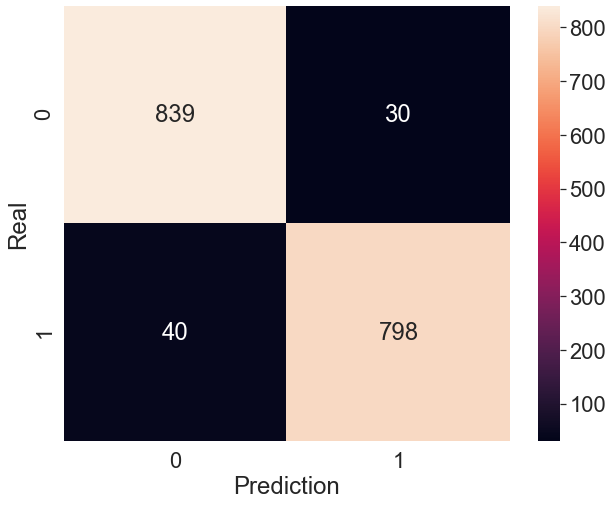

In [37]:
confusion_matrix_description(linear_confusion_matrix)

In [38]:
modelNB = MultinomialNB()
modelNB.fit(train_x, train_y)
predictions = modelNB.predict(test_x)
score = np.around(accuracy_score(test_y, predictions)*100,decimals=2)
print(f'Acurácia do modelo Multinomial de Naive Bayes é: {score}%')

Acurácia do modelo Multinomial de Naive Bayes é: 95.84%


In [39]:
nb_confusion_matrix = confusion_matrix(test_y, predictions)
nb_confusion_matrix

array([[848,  21],
       [ 50, 788]], dtype=int64)

Verdadeiro Negativo(Diz que não é bot e não é): 848, 97.58% do total
Falso positivo(Diz que é bot, mas não é): 21, 2.42% do total
Falso Negativo(Diz que não é bot, mas é ): 50, 5.97% do total
Verdadeiro Positivo(Diz que é bot e é ): 788, 94.03% do total
MCC: 0.92


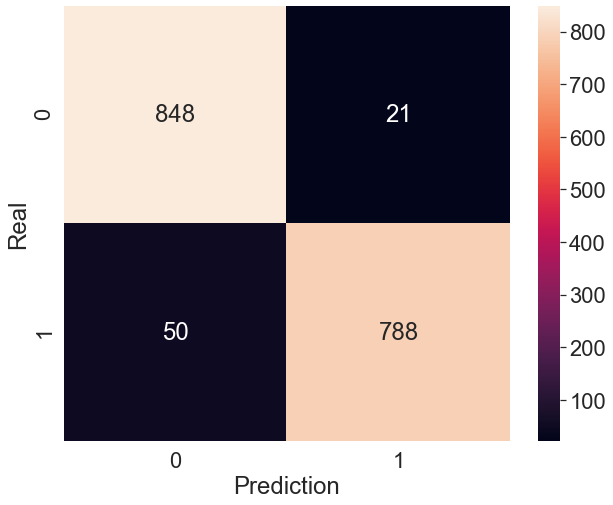

In [40]:
confusion_matrix_description(nb_confusion_matrix)

In [41]:
modelDecisionTree = DecisionTreeClassifier()
modelDecisionTree.fit(train_x, train_y)
predictions = modelDecisionTree.predict(test_x)
score = np.around(accuracy_score(test_y, predictions)*100,decimals=2)
print(f'Acurácia da árvore de decisão é: {score}%')

Acurácia da árvore de decisão é: 95.9%


In [42]:
dt_confusion_matrix = confusion_matrix(test_y, predictions)
dt_confusion_matrix

array([[841,  28],
       [ 42, 796]], dtype=int64)

Verdadeiro Negativo(Diz que não é bot e não é): 841, 96.78% do total
Falso positivo(Diz que é bot, mas não é): 28, 3.22% do total
Falso Negativo(Diz que não é bot, mas é ): 42, 5.01% do total
Verdadeiro Positivo(Diz que é bot e é ): 796, 94.99% do total
MCC: 0.92


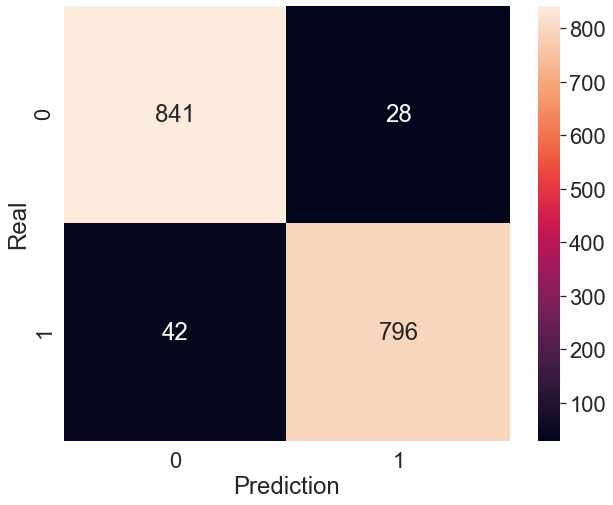

In [43]:
confusion_matrix_description(dt_confusion_matrix)

Para analisar as decisões tomadas pelo algoritmo da árvore de decisão, podemos usar a seguinte visualização:

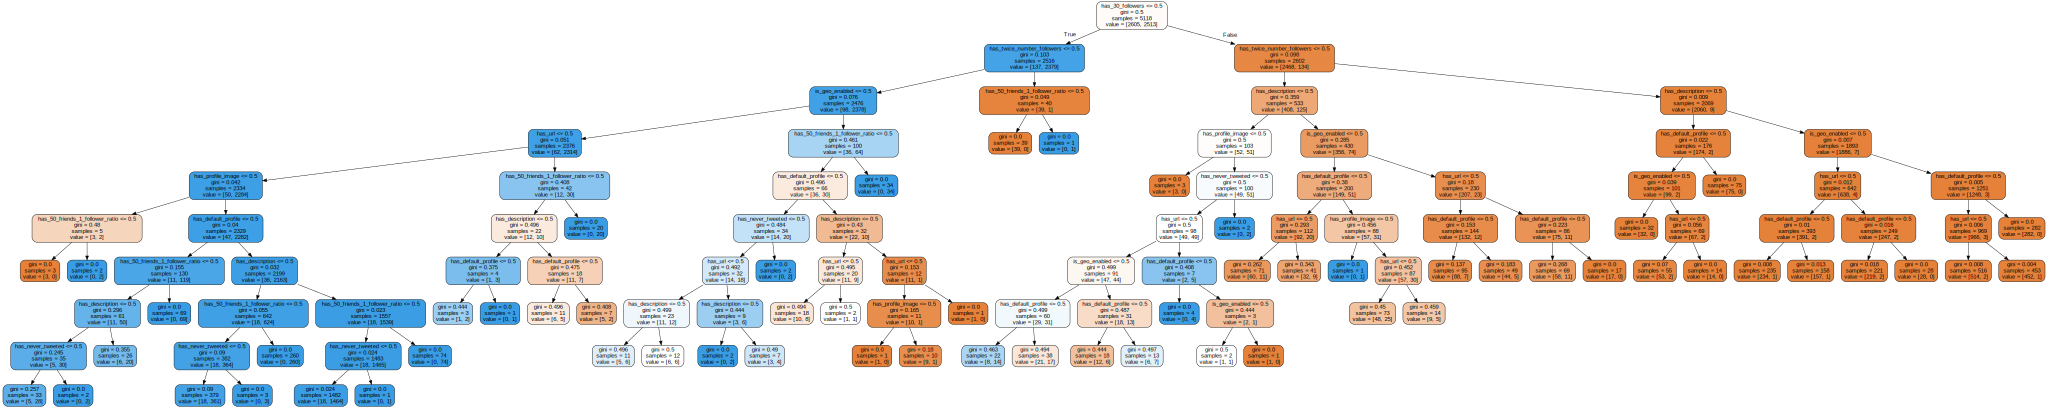

In [44]:
dot_data = export_graphviz(modelDecisionTree,out_file =None, feature_names=x.columns, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

Até então, podemos extrair algumas informações valiosas referentes aos nossos dados. Contudo, na divisão dos dados de treino e de teste estamos fortemente dependente da seed que foi definida(random_state = 0). 
Por estarmos sempre utilizando o mesmo treino e o mesme teste, podemos acabar tendo um grupo de dados extramemente específicos que podem enviesando nosso algoritmo.

Portanto, será necessário aleatorizar o nossos treinos e testes a fim de mitigar as possíveis inconsistências, para isso utilizaremos o StratifiedKFold que definirá diferentes grupos randomicos de teste e treino, mantendo sempre a estratificação que foi explicada anteriormente.

### StratifiedKFold

Para facilitar a visualização dos dados referentes ao cross validate mostraremos o intervalo de acurácia para os diferentes grupos de treino/teste e a acurácia média:

In [45]:
def cross_validation_description(results, model):
    std_dev = results['test_score'].std()
    mean = results['test_score'].mean()
    mean_p = np.around(mean *100, decimals=2)
    min_interval = np.around((mean - 2 * std_dev)*100,decimals = 2)
    max_interval = np.around((mean + 2 * std_dev) *100, decimals = 2)
    print(f'Intervalo de Acurácia do {model} é: [{min_interval}%, {max_interval}%] ')
    print(f'Média de Acurácia: {mean_p}%')

Quanto as parâmetros, temos que n_splits representa a quantidade de grupos(5 grupos de 1365) que serão criados e shuffle = True presenta que os dados serão embaralhados.

In [46]:
cv = StratifiedKFold(n_splits = 5, shuffle = True)

##### LinearSVC

In [47]:
results = cross_validate(modelLinear, x, y, cv = cv, return_train_score=False)
cross_validation_description(results,'LinearSVC')

Intervalo de Acurácia do LinearSVC é: [94.52%, 96.52%] 
Média de Acurácia: 95.52%


##### Multinomial Naive Bayes

In [48]:
results = cross_validate(modelNB, x, y, cv = cv, return_train_score=False)
cross_validation_description(results,'Multinomial Naive Bayes')

Intervalo de Acurácia do Multinomial Naive Bayes é: [95.08%, 96.1%] 
Média de Acurácia: 95.59%


##### Decision Tree

In [49]:
results = cross_validate(modelDecisionTree, x, y, cv = cv, return_train_score=False)
cross_validation_description(results,'Decision Tree')

Intervalo de Acurácia do Decision Tree é: [93.99%, 97.24%] 
Média de Acurácia: 95.62%


### TSNE

Para visualizar a distruibuição da nossas classes no espaço, utilizaremos o algoritmos TSNE que, resumidamente, tranforma dados de muitas dimensões em dados com dimensões reduzidas mantendo o máximo de informação que for possível. 

<AxesSubplot:>

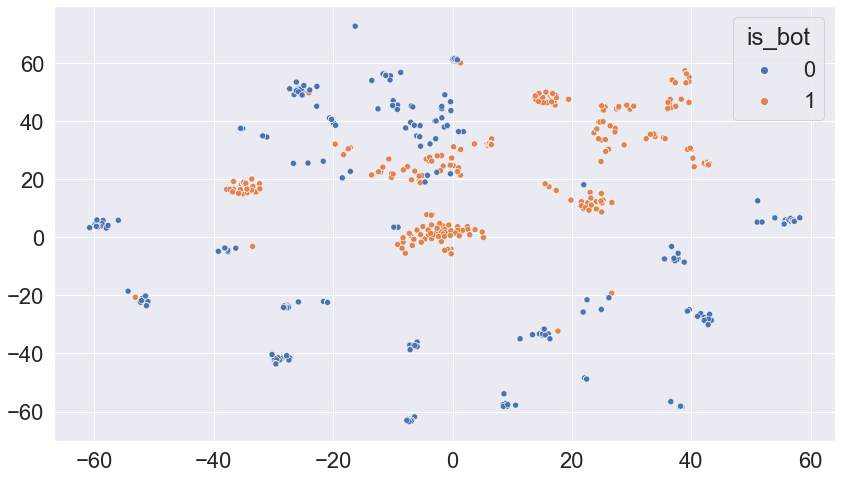

In [50]:
tsne = TSNE(n_components = 2)
tsne_dimensions = tsne.fit_transform(binary_matrix_train)
plt.figure(figsize=(14,8))
sns.scatterplot(x = tsne_dimensions[:,0] ,y = tsne_dimensions[:,1], hue = binary_matrix_train['is_bot'])

### Entendendo a distrubuição das features

##### BOTS

A seguir analisaremos as distruibuições das features em nossas duas classes, primeiramente para os perfis genuinos

In [177]:
size = binary_matrix_train[binary_matrix_train.is_bot == 1].shape[0]
bot_description_matrix = binary_matrix_train[binary_matrix_train.is_bot == 1].apply(pd.Series.value_counts)
bot_description_matrix = bot_description_matrix.T

In [193]:
bot_description_matrix = bot_description_matrix.assign(percentage_0 = np.around(bot_description_matrix[0]/size *100,decimals=2),
                              percentage_1 = np.around(bot_description_matrix[1]/size *100,decimals=2))
bot_description_matrix.fillna(0, inplace=True)
bot_description_matrix

,0,1,percentage_0,percentage_1
has_description,1073.0,2278.0,30.89,65.57
has_url,3250.0,101.0,93.55,2.91
is_geo_enabled,3212.0,139.0,92.46,4.00
has_default_profile,317.0,3034.0,9.12,87.33
has_profile_image,6.0,3345.0,0.17,96.29
has_twice_number_followers,3338.0,13.0,96.09,0.37
has_100_friends_1_follower_ratio,2998.0,353.0,86.30,10.16
has_50_friends_1_follower_ratio,2725.0,626.0,78.44,18.02
has_30_followers,3179.0,172.0,91.51,4.95
has_never_tweeted,3213.0,138.0,92.49,3.97


Portanto, inicialmente temos que as caracteristicas mais comuns aos bots são:
Ter descrição, não ter url atrelada ao perfil, não estar geolocalizado, ter perfil padrão(ou seja, nunca alterou o tema do twitter ou background), ter foto de perfil, não ter o dobro de seguidores em relação aos amigos, não ter a razão 100 amigos a cada 1 seguidor, não ter a razão 50 amigos a cada 1 seguidor, não ter 30 seguidores, não ter 50 tweets, não ter mais de 1000 seguidores, e não ser verificado.

##### PERFIS GENUÍNOS

In [187]:
size = binary_matrix_train[binary_matrix_train.is_bot == 0].shape[0]
gp_description_matrix = binary_matrix_train[binary_matrix_train.is_bot == 0].apply(pd.Series.value_counts)
gp_description_matrix = gp_description_matrix.T

In [192]:
gp_description_matrix = gp_description_matrix.assign(percentage_0 = np.around(gp_description_matrix[0]/size *100,decimals=2),
                              percentage_1 = np.around(gp_description_matrix[1]/size *100,decimals=2))
gp_description_matrix.fillna(0, inplace=True)
gp_description_matrix

,0,1,percentage_0,percentage_1
has_description,379.0,3095.0,10.91,89.09
has_url,2208.0,1266.0,63.56,36.44
is_geo_enabled,1319.0,2155.0,37.97,62.03
has_default_profile,2442.0,1032.0,70.29,29.71
has_profile_image,13.0,3461.0,0.37,99.63
has_twice_number_followers,678.0,2796.0,19.52,80.48
has_100_friends_1_follower_ratio,3474.0,0.0,100.00,0.00
has_50_friends_1_follower_ratio,3474.0,0.0,100.00,0.00
has_30_followers,183.0,3291.0,5.27,94.73
has_never_tweeted,3474.0,0.0,100.00,0.00


Portanto, inicialmente temos que as caracteristicas mais comuns aos perfis genuínos são:
Ter descrição, não ter url atrelada ao perfil, estar geolocalizado, não ter perfil padrão, ter foto de perfil, não ter o dobro de seguidores em relação aos amigos, não ter a razão 100 amigos a cada 1 seguidor, não ter a razão 50 amigos a cada 1 seguidor,  ter 30 seguidores, não ter 50 tweets, não ter mais de 1000 seguidores, e não ser verificado.

##### ORANGE

Para entender melhor o gráfico do TSNE mostrado anteriormente, utilizaremos um programa chamado Orange que facilitará o entendimento dos diferentes "agrupamentos" existentes no gráfico. Note que a visualização diverge um pouco da anterior, porém, trata-se da aplicação do mesmo algoritmo sobre a mesma base de dados, o que muda são as configurações de jittering para facilitar a visualização.

Os agrupamentos que serão analisados serão aqueles que possuem interseção entre a classe bot e a classe de perfil genuíno

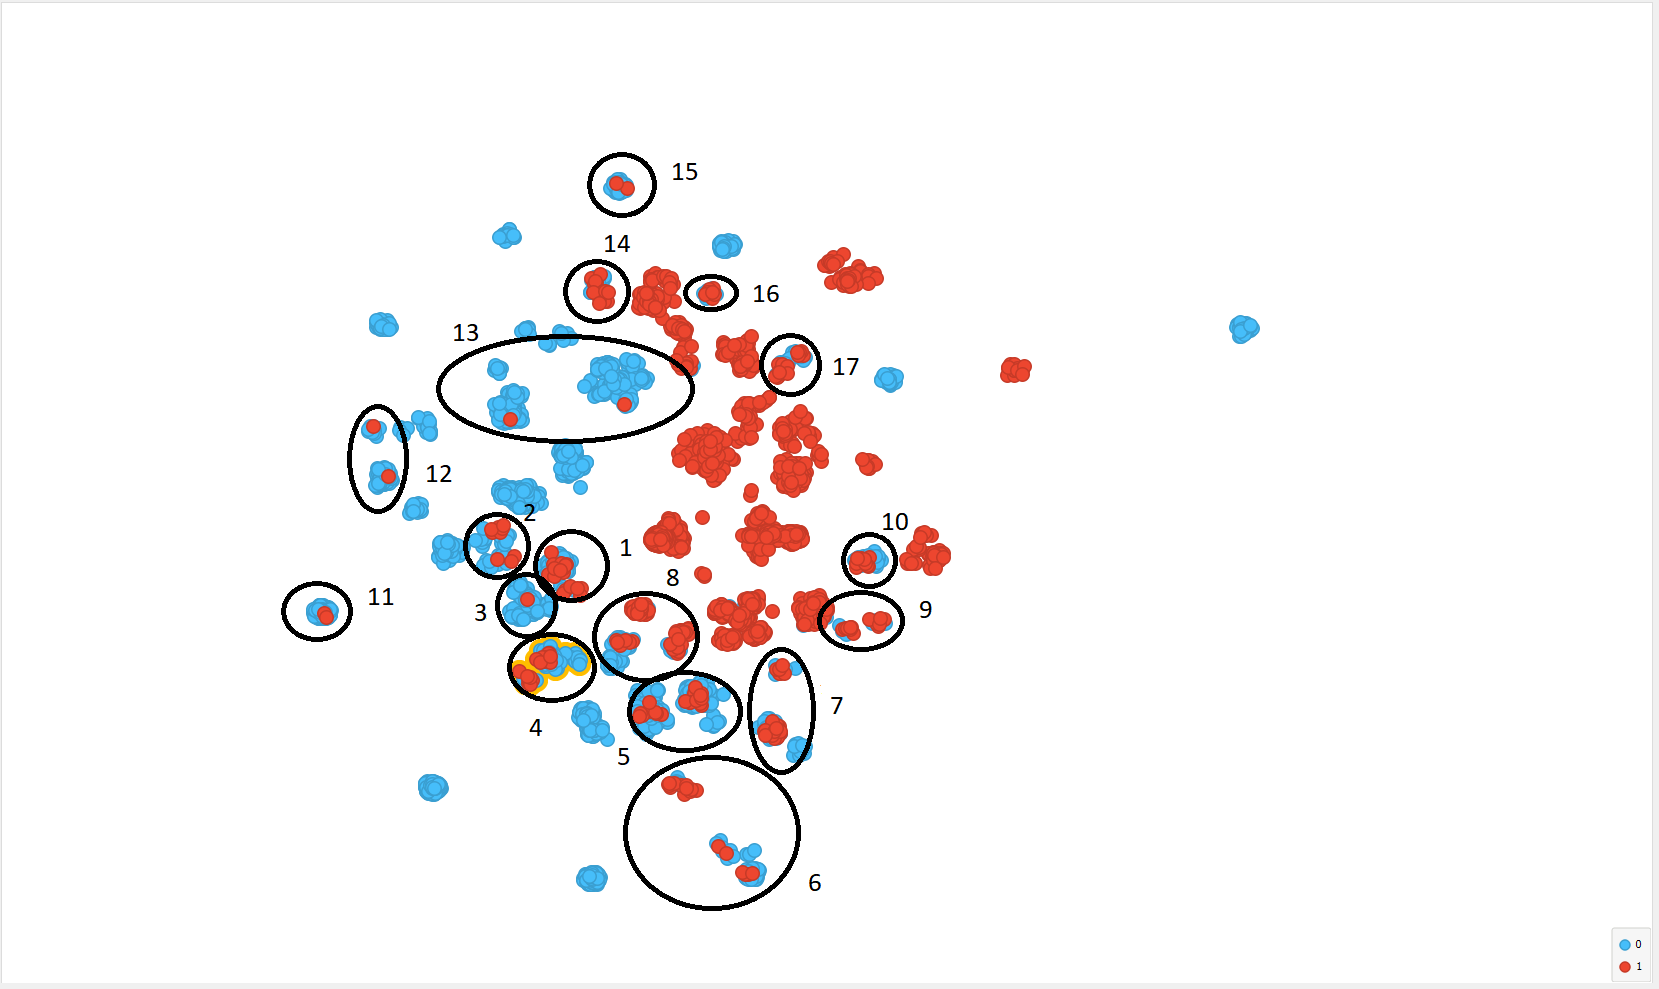


###### AGRUPAMENTO 1 - 103 REGISTROS, 84 PERFIS GENUÍNOS(PG), 19 BOTS

TEM DESCRIÇÃO; TEM URL; ESTÁ GEOLOCALIZADO; NÃO TEM PERFIL PADRÃO;
TEM FOTO DE PERFIL; NÃO TEM O DOBRO DE SEGUIDORES EM RELAÇÃO AO 
NÚMERO DE AMIGOS; NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR;
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR; TEM 30 SEGUIDORES;
TEM MAIS DE 50 TWEETS; NÃO TEM 1000 SEGUIDORES; NÃO É VERIFICADO.

###### AGRUPAMENTO 2 - 44 REGISTROS, 35 PERFIS GENUÍNOS(PG), 9 BOTS	

NÃO TEM DESCRIÇÃO; TEM URL; É GEOLOCALIZADO; MISTO ENTRE SIM E NÃO 
DE CONTAS COM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; PERFIS GENUÍNOS 
TEM O DOBRO DE SEGUIDORES, BOTS NÃO; NÃO TEM A RAZÃO DE 100 AMIGOS 
A CADA 1 SEGUIDOR; NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
PARA PERFIS GENUÍNOS TEM 30 SEGUIDORES, MISTO PARA BOTS; TEM 50
TWEETS, NÃO TEM 1000 SEGUIDORES, NÃO SÃO VERIFICADOS 


###### AGRUPAMENTO 3 - 168 REGISTROS, 167 PERFIS GENUÍNOS(PG), 1 BOTS	

TEM DESCRIÇÃO, TEM URL, NÃO TEM GEOLOCALIZAÇÃO, NAÕ TEM PERFIL
PADRÃO, TEM IMAGEM DE PERFIL, TEM O DOBRO DE SEGUIDORES, 
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES, TEM 50 TWEETS, NÃO TEM 1000 SEGUIDORES,
NÃO É VERIFICADO

###### AGRUPAMENTO 4 - 80 REGISTROS, 63 PERFIS GENUÍNOS(PG), 17 BOTS

TEM DESCRIÇÃO, TEM URL, NÃO TEM GEOLOCALIZAÇÃO; NÃO TEM PERFIL
PADRÃO; TEM IMAGEM DE PERFIL, NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
SIM PARA PERFIS GENUÍNOS, MISTO PARA BOTS;
TEM 50 TWEETS, NÃO TEM 1000 SEGUIDORES, NÃO É VERIFICADO

###### AGRUPAMENTO 5 - 229 REGISTROS, 205 PERFIS GENUÍNOS(PG), 24 BOTS

TEM DESCRIÇÃO; NÃO TEM URL; MISTO PARA GEOLOCALIZAÇÃO; NÃO TEM 
PERFIL PADRÃO; TEM IMAGEM DE PERFIL; NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS, NÃO TEM 1000 SEGUIDORES;
NÃO É VERIFICADO

###### AGRUPAMENTO 6 - 102 REGISTROS, 84 PERFIS GENUÍNOS(PG), 18 BOTS	

TEM DESCRIÇÃO; NÃO TEM URL; É GEOLOCALIZADO; PERFIS GENUÍNOS
TEM PERFIL PADRÃO, MISTO PARA BOT; TEM IMAGEM DE PERFIL;
NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
PERFIS GENUÍNOS TEM 30 SEGUIDORES, MISTO PARA BOTS;
PERFIS GENUÍNOS TEM 50 TWEETS, MISTO PARA BOTS;
NÃO TEM 1000 SEGUIDORES; NÃO É VERIFICADO

###### AGRUPAMENTO 7 - 113 REGISTROS, 76 PERFIS GENUÍNOS(PG), 37 BOTS	

TEM DESCRICÃO; NÃO TEM URL; NÃO ESTÁ GEOLOCALIZADO;
TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; NÃO TEM O DOBRO DE
SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS, NÃO TEM 1000 SEGUIDORES;
NÃO É VERIFICADO

###### AGRUPAMENTO 8 - 112 REGISTROS, 78 PERFIS GENUÍNOS(PG), 34 BOTS


TEM DESCRIÇÃO; BOTS NÃO TEM URL; MISTO PARA PERFIS GENUÍNOS;
NÃO ESTÁ GEOLOCALIZADO; TEM PERFIL PADRÃO(QUASE MISTO);
TEM IMAGEM DE PERFIL; NÃO TEM DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
NÃO TEM 30 SEGUIDORES;
BOTS NÃO TEM 50 TWEETS, PERFIS GENUÍNOS TEM;
NÃO TEM 1000 SEGUIDORES; NÃO É VERIFICADO


###### AGRUPAMENTO 9 - 33 REGISTROS, 19 PERFIS GENUÍNOS(PG), 14 BOTS

NÃO TEM DESCRIÇÃO; NÃO TEM URL; NÃO TEM GEOLOCALIZAÇÃO;
TEM PERFIL PADRÃO; MISTO PARA IMAGEM DE PERFIL; NÃO TEM O DOBRO
DE SEGUIDORES(QUASE MISTO PARA PERFIS GENUÍNOS);
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
SIM, QUASE MISTO PARA 30 SEGUIDORES;
MISTO PARA 50 TWEETS; NÃO TEM 1000 SEGUIDORES; NÃO É VERIFICADO

###### AGRUPAMENTO 10 - 46 REGISTROS, 33 PERFIS GENUÍNOS(PG), 13 BOTS


NÃO TEM DESCRIÇÃO; NÃO TEM URL, NÃO TEM GEOLOCALIZAÇÃO;
TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; NÃO TEM DOBRO DE SEGUIDORES
MAS POSSUI ALGUNS RESULTADOS SIGNIFICATIVOS PARA SIM;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; NÃO TEM 1000 SEGUIDORES;
NÃO É VERIFICADO;

###### AGRUPAMENTO 11 - 512 REGISTROS, 510 PERFIS GENUÍNOS(PG), 2 BOTS

TEM DESCRIÇÃO; NÃO TEM URL; É GEOLOCALIZADO, NÃO TEM PERIL PADRÃO;
TEM IMAGEM DE PERFIL; TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; NÃO TEM 1000 SEGUIDORES;
NÃO É VERIFICADO

###### AGRUPAMENTO 12 - 92 REGISTROS, 90 PERFIS GENUÍNOS(PG), 2 BOTS

TEM DESCRICÃO, NÃO TEM URL; ESTÁ GEOLOCALIZADO; NÃO TEM PERFIL PADRÃO
PARA PERFIS GENUÍNOS, MISTO PARA BOTS; TEM IMAGEM DE PRFIL;
TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; TEM 1000 SEGUIDORES; NÃO É VERIFICADO

###### AGRUPAMENTO 13 - 352 REGISTROS, 350 PERFIS GENUÍNOS(PG), 2 BOTS

TEM DESCRIÇÃO; TEM URL; TEM GEOLOCALIZAÇÃO MAS RESULTADOS NEGATIVOS SIGNIFICATIVOS PARA PERFIS GENUÍNOS, MISTO PARA BOTS. POSSIVEL PONTO DE DIVISÃO DENTRO DO MESMO CLUSTER(GRANDE DISTÂNCIA, OLHAR NA IMAGEM);
NÃO TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; TEM 1000 SEGUIDORES;
NÃO É VERIFICADO

###### AGRUPAMENTO 14 -  39 REGISTROS, 23 PERFIS GENUÍNOS(PG), 16 BOTS

NÃO TEM DESCRIÇÃO; NÃO TEM URL; ESTÁ GEOLOCALIZADO;
NÃO TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL;
NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES PARA PERFIS GENUÍNOS, MISTO PARA BOT;
TEM 50 TWEETS PARA PERFIS GENUÍNOS, MISTO PARA BOT;
NÃO TEM 1000 SEGUIDORES


###### AGRUPAMENTO 15 -  55 REGISTROS, 53 PERFIS GENUÍNOS(PG), 2 BOTS	

NÃO TEM DESCRIÇÃO; NÃO TEM URL; TEM GEOLOCALIZAÇÃO;
NÃO TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; NÃO É VERIFICADO


###### AGRUPAMENTO 16 - 24 REGISTROS, 14 PERFIS GENUÍNOS(PG), 10 BOTS


NÃO TEM DESCRIÇÃO; NÃO TEM URL; NÃO TEM GEOLOCALIZAÇÃO;
NÃO TEM PERFIL PADRÃO; TEM IMAGEM DE PERFIL; NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
TEM 30 SEGUIDORES; TEM 50 TWEETS; NÃO TEM 1000 SEGUIDORES;
NÃO É VERIFICADO


###### AGRUPAMENTO 17 - 45 REGISTROS, 26 PERFIS GENUÍNOS(PG), 19 BOTS

TEM DESCRIÇÃO; NÃO TEM URL; É GEOLOCALIZADO; TEM PERFIL PADRÃO;
TEM IMAGEM DE PERFIL; NÃO TEM O DOBRO DE SEGUIDORES;
NÃO TEM A RAZÃO DE 100 AMIGOS A CADA 1 SEGUIDOR; 
NÃO TEM A RAZÃO DE 50 AMIGOS A CADA 1 SEGUIDOR;
MISTO PARA 30 SEGUIDORES; PERFIS GENUÍNOS TEM 50 TWEETS, BOTS NÃO;
NÃO É VERIFICADO

###### JUNÇÃO DE TODOS OS AGRUPAMENTOS

86.32% TEM DESCRIÇÃO
64.16% NÃO TEM URL
58.13% PG ESTÃO GEOLOCALIZADOS, 79% BOTS NÃO TEM
80.47% TEM PERFIL PADRÃO
99.11% TEM IMAGEM DE PERFIL

